In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_state_city
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit import transpile, QuantumCircuit
import numpy as np

## Showing optimal strategies for a 3 player MOE game with $\pi=1/2$

In [153]:
# aersim -- simulates the winning percentage of a game with 1/2 chance in each basis
def aersim(qc, qch, n, num_measures):
    total0 = 0
    backend = AerSimulator()
    job = backend.run(qc, shots=n)
    result = job.result()
    counts = result.get_counts()
    print(counts)
    if(num_measures == 1):
        total0 = counts.get('0', 0)
    else:
        total0 = counts.get('000', 0) + counts.get('111', 0)
    job = backend.run(qch, shots=n)
    result = job.result()
    counts = result.get_counts()
    print(counts)
    if(num_measures == 1):
        total0 += counts.get('0', 0)
    else:
        total0 += counts.get('000', 0) + counts.get('111', 0)
    
    print(f"Win Percentage: {total0 / (2 * n)}")

In [155]:
# Save account credentials once
QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token="INSTERT TOKEN",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/847a127bbbd443bda21b2f8eb34fcf05:c89422dd-3ac6-4a78-9014-cd25fa6dfada::",
    overwrite="True"
)

# load the service
service = QiskitRuntimeService(channel="ibm_cloud")


# 3. Choose a real QPU backend
backend = service.least_busy(simulator=False, operational=True)  # 🔍 finds least pending jobs :contentReference[oaicite:1]{index=1}
print(f"Using backend: {backend}")

Using backend: <IBMBackend('ibm_sherbrooke')>


### Strategy 1: Unentangled strategy where $|\psi\rangle=(\cos(\frac{\pi}{8})|0\rangle + \sin(\frac{\pi}{8})|1\rangle) \otimes |0\rangle \otimes |0\rangle$

In [141]:
# Computational Basis Measurement 
qc = QuantumCircuit(3,1)

theta = 2 * np.pi / 8  # because RY(θ) gives cos(θ/2)|0⟩ + sin(θ/2)|1⟩
qc.ry(theta, 0)
# Hadamard Measurement
qch = QuantumCircuit(3,1)
qch.ry(theta, 0)
qch.h(0)
qch.h(1)
qch.h(2)

# Get the statevector
state = Statevector.from_instruction(qc)
#state.draw('bloch')

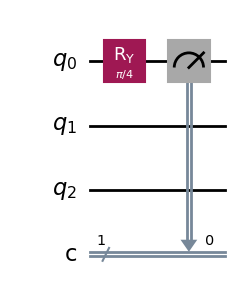

In [142]:
qc.measure(0, 0)


# Show circuit
qc.draw('mpl')

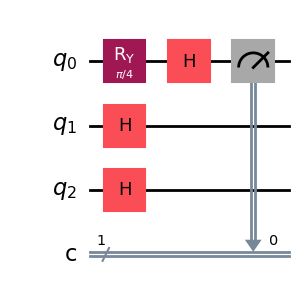

In [145]:
# Show circuit
qch.measure(0, 0)
qch.draw('mpl')

In [146]:
aersim(qc, qch, 10000000, 1)

Win Percentage: 0.85343025


## Strategy 2 where $|\psi\rangle = \frac{(|00\rangle + |11\rangle)}{\sqrt{2}} \otimes |0\rangle$

In [134]:
# Computational Basis Measurement 
qc2 = QuantumCircuit(3,3)

qc2.h(0)
qc2.cx(0,1)
qc2.measure([0, 1, 2],[0, 1, 2])

# Hadamard Measurement
qch2 = QuantumCircuit(3,3)
qch2.h(0)
qch2.cx(0,1)

qch2.h(0)
qch2.h(1)
qch2.h(2)
qch2.measure([0, 1, 2],[0, 1, 2])


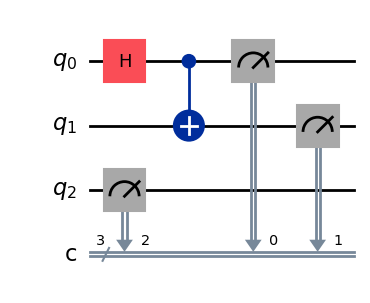

In [135]:
qc2.draw('mpl')

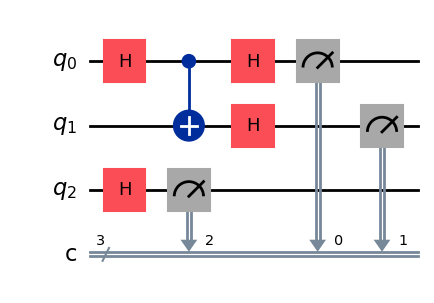

In [136]:
qch2.draw('mpl')

In [109]:
aersim(qc2, qch2, 100000, 3)

Win Percentage: 0.49805


## Strategy 3 where $|\psi\rangle = |GHZ\rangle$

In [147]:
# Computational Basis Measurement 
qc3 = QuantumCircuit(3,3)
qc3.h(0)
qc3.cx(0,1)
qc3.cx(1,2)
qc3.measure([0, 1, 2],[0, 1, 2])
# Hadamard Measurement
qch3 = QuantumCircuit(3,3)
qch3.h(0)
qch3.cx(0,1)
qch3.cx(1,2)
qch3.h(0)
qch3.h(1)
qch3.h(2)
qch3.measure([0, 1, 2],[0, 1, 2])


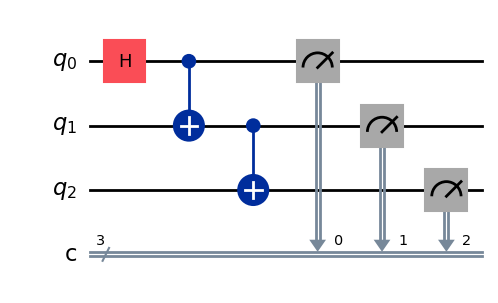

In [148]:

qc3.draw('mpl')

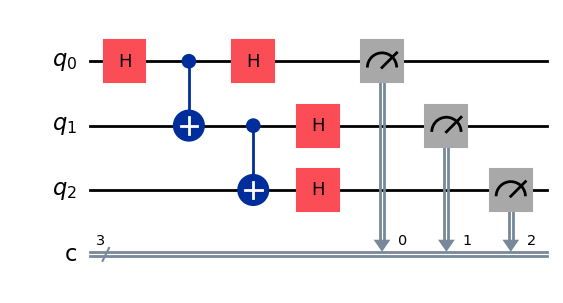

In [149]:
qch3.draw('mpl')

In [154]:
aersim(qc3, qch3, 100000, 3)

{'111': 49719, '000': 50281}
{'101': 25099, '110': 25139, '000': 24826, '011': 24936}
Win Percentage: 0.62413


In [166]:
# Save account credentials once
QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token="hbayn1Pm32HKh9Nw_mLpbkmtscO8YAaLKHTaC2ELREoy",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/847a127bbbd443bda21b2f8eb34fcf05:c89422dd-3ac6-4a78-9014-cd25fa6dfada::",
    overwrite="True"
)

# load the service
service = QiskitRuntimeService(channel="ibm_cloud")


# 3. Choose a real QPU backend
backend = service.least_busy(simulator=False, operational=True)  # 🔍 finds least pending jobs :contentReference[oaicite:1]{index=1}
print(f"Using backend: {backend}")

num_samples = 5000

Using backend: <IBMBackend('ibm_brisbane')>


In [167]:
qc_t = transpile(
    qc,
    backend=backend,
    optimization_level=3,
    scheduling_method="alap",      
    routing_method="sabre"          
)

# 5. Run on real hardware using Sampler
sampler = Sampler(backend)          
sampler.options.default_shots = num_samples

job = sampler.run([qc_t])
res = job.result()[0]
counts = res.join_data().get_counts()
print("Combined counts:", counts)

Combined counts: {'0': 4241, '1': 759}


In [168]:
qch_t = transpile(
    qch,
    backend=backend,
    optimization_level=3,
    scheduling_method="alap",      
    routing_method="sabre"          
)

# 5. Run on real hardware using Sampler
sampler = Sampler(backend)          
sampler.options.default_shots = num_samples

job = sampler.run([qch_t])
res = job.result()[0]
counts = res.join_data().get_counts()
print("Combined counts:", counts)

Combined counts: {'0': 4229, '1': 771}


In [169]:
qc2_t = transpile(
    qc2,
    backend=backend,
    optimization_level=3,
    scheduling_method="alap",      
    routing_method="sabre"          
)

# 5. Run on real hardware using Sampler
sampler = Sampler(backend)          
sampler.options.default_shots = num_samples

job = sampler.run([qc2_t])
res = job.result()[0]
counts = res.join_data().get_counts()
print("Combined counts:", counts)

Combined counts: {'011': 2452, '000': 2366, '001': 46, '010': 102, '111': 20, '100': 12, '110': 2}


In [170]:
qch2_t = transpile(
    qc2,
    backend=backend,
    optimization_level=3,
    scheduling_method="alap",      
    routing_method="sabre"          
)

# 5. Run on real hardware using Sampler
sampler = Sampler(backend)          
sampler.options.default_shots = num_samples

job = sampler.run([qch2_t])
res = job.result()[0]
counts = res.join_data().get_counts()
print("Combined counts:", counts)

Combined counts: {'000': 2369, '011': 2453, '010': 89, '001': 55, '100': 14, '111': 19, '110': 1}


In [171]:
qc3_t = transpile(
    qc3,
    backend=backend,
    optimization_level=3,
    scheduling_method="alap",      
    routing_method="sabre"          
)

# 5. Run on real hardware using Sampler
sampler = Sampler(backend)          
sampler.options.default_shots = num_samples

job = sampler.run([qc3_t])
res = job.result()[0]
counts = res.join_data().get_counts()
print("Combined counts:", counts)

Combined counts: {'111': 2452, '000': 2325, '110': 49, '011': 25, '001': 50, '101': 16, '100': 65, '010': 18}


In [172]:
qch3_t = transpile(
    qch3,
    backend=backend,
    optimization_level=3,
    scheduling_method="alap",      
    routing_method="sabre"          
)

# 5. Run on real hardware using Sampler
sampler = Sampler(backend)          
sampler.options.default_shots = num_samples

job = sampler.run([qch3_t])
res = job.result()[0]
counts = res.join_data().get_counts()
print("Combined counts:", counts)

Combined counts: {'101': 1236, '110': 1281, '000': 1214, '011': 1077, '010': 62, '111': 44, '100': 45, '001': 41}
